<a href="https://colab.research.google.com/github/chr1stine/circle-polygon-classifier/blob/master/geometry_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерирование данных

In [13]:
import matplotlib
import numpy
import cv2
import pickle
import pandas
import torch
import torchvision
import PIL

import matplotlib.pyplot as plt
from numpy import random
from math import sqrt,sin,cos,pi

import os
import cv2
import numpy as np

from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_auc_score

print('matplotlib '+matplotlib.__version__)
print('numpy '+numpy.__version__)
print('cv2 '+cv2.__version__)
print('pandas '+pandas.__version__)
print('torch '+torch.__version__)
print('torchvision '+torchvision.__version__)
print('PIL '+PIL.__version__)

matplotlib 3.2.2
numpy 1.19.5
cv2 4.1.2
pandas 1.1.5
torch 1.8.1+cu101
torchvision 0.9.1+cu101
PIL 7.1.2


## Генерация картинок для датасета

In [9]:
n = 4000 # кол-во картинок для каждого класса
img_size = 128 # размер каждой картинки

### Круги

In [4]:
# создать папку если такой нет
directory = './figures/circles'
if not os.path.exists(directory):
    os.makedirs(directory)

#параметры - координаты, радиус
def gen_circle(i):
    fig = plt.figure(figsize=(5, 5), dpi=100)

    plt.xlim(0,5)
    plt.ylim(0,5)

    c = (random.rand()*4+1,random.rand()*4+1)
    r = random.rand()*min(c[0],c[1],5-c[0],5-c[1])+random.rand()
    circle = plt.Circle(c, radius=r)
    fig.gca().add_patch(circle)
    fig.gca().set_axis_off()
    plt.savefig('./figures/circles/circle'+str(i)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()
    
for i in range(n):
    gen_circle(i)

### Квадраты

In [6]:
# создать папку если такой нет
directory = './figures/squares'
if not os.path.exists(directory):
    os.makedirs(directory)

def gen_square(i):
    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    x0 = random.rand()*4
    y0 = random.rand()*4
    a = random.rand()*3
    
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    points = []
    
    x = x0-a/2.
    y = y0-a/2
    points.append((x,y))
    
    x = x0-a/2.
    y = y0+a/2.
    points.append((x,y))
    
    x = x0+a/2.
    y = y0+a/2.
    points.append((x,y))
    
    x = x0+a/2.
    y = y0-a/2.
    points.append((x,y))
    
    tetragon = plt.Polygon(points)
    fig.gca().add_patch(tetragon)    
    fig.gca().set_axis_off()
    plt.savefig('figures/squares/square'+str(i)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()
    
    
for i in range(n):
    gen_square(i)

## Создание датасета

In [7]:
file_list = []
class_list = []

folder = "figures"

categories = ["circles", "squares"]

# Checking or all images in the data folder
for category in categories :
    path = os.path.join(folder, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

# массив пар (картинка, класс)
training_data = []

def create_training_data():
    for category in categories :
        path = os.path.join(folder, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

# свойства
X = []

# ярлыки
y = []

# в features "попадают" сами картинки, в label - классы
for features, label in training_data:
    X.append(features)
    y.append(label)

# из списка матриц пикселей картинки получаем матрицу списков пикселей картинок
X = np.array(X).reshape(-1, img_size, img_size, 1)

# сериализуем датасет в файл
pickle_out = open("features.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("labels.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Создание класса для датасета

In [10]:
class figures_dataset(Dataset):
    def __init__(self):
        features_fname = 'features.pickle'
        labels_fname = 'labels.pickle'
            
        # десериализация картинок
        f_pickle_in = open(features_fname,'rb')
        self.images = pickle.load(f_pickle_in,encoding='bytes')
        
        # десериализация меток
        l_pickle_in = open(labels_fname,'rb')
        self.labels = pickle.load(l_pickle_in,encoding='bytes')
        
        # аугментация и зашумление картинок
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.GaussianBlur(9,9),
            transforms.ToTensor()
        ])
        self.noise = torch.rand(len(self.images),img_size,img_size,1)
        
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # проверка, что индекс "массивоподобный"
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # возвращение словаря <картинка,метка>
        image = self.images[idx]
        label = self.labels[idx]
            
        image = image + np.array(self.noise[idx])
        image = self.transform(image)
        sample = image, label

        
        return sample

figures = figures_dataset()

# Обучение нейросети

## Вызов DataLoader и объявление нейросети

In [14]:
# деление датасета на обучающую и проверяющую выборки
validation_split = .2
figures_size = len(figures)
indices = list(range(figures_size))
shuffle(indices)
split = int(np.floor(validation_split * figures_size))
train_indices, test_indices = indices[split:], indices[:split]

# перемешивает индексы
test = SubsetRandomSampler(test_indices)
train = SubsetRandomSampler(train_indices)

# размер батча
b_size=32

test_set = DataLoader(figures, batch_size=b_size, sampler=test)
train_set = DataLoader(figures, batch_size=b_size, sampler=train)


sigm = nn.Sigmoid()
# нейросеть
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()                
        self.conv1 = torch.nn.Conv2d(1, 3, 3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(3, 6, 3)
        self.conv3 = torch.nn.Conv2d(6,12,3)
        self.fc1 = torch.nn.Linear(12 * 14 * 14, 1)
        self.dout = torch.nn.Dropout(0.5)    
    def forward(self, x):
        x = self.dout(self.pool(torch.nn.functional.relu(self.conv1(x))))
        x = self.dout(self.pool(torch.nn.functional.relu(self.conv2(x))))
        x = self.dout(self.pool(torch.nn.functional.relu(self.conv3(x))))
        x = torch.flatten(x,1)
        x = sigm(self.fc1(x))
        return x
net = Net()

# loss-функция
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Запуск обучения и вывод графика loss

[1,   200] loss: 0.693
[2,   200] loss: 0.689
[3,   200] loss: 0.667
[4,   200] loss: 0.593
[5,   200] loss: 0.421
[6,   200] loss: 0.290
[7,   200] loss: 0.249
[8,   200] loss: 0.221
[9,   200] loss: 0.212
[10,   200] loss: 0.204
[11,   200] loss: 0.190
[12,   200] loss: 0.177
[13,   200] loss: 0.170
[14,   200] loss: 0.155
[15,   200] loss: 0.145
Finished Training


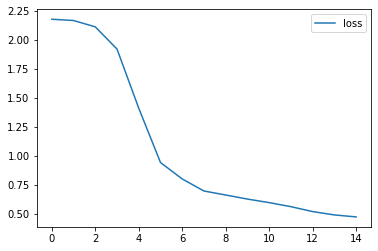

In [15]:
epochs = 15
loss_vals = []
for epoch in range(epochs):

    running_loss = 0.0 # для вывода по каждым freq мини-батчам
    loss_val = 0.0 # для вывода общего loss по эпохе
    for i, data in enumerate(train_set, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        # вывод loss
        running_loss += loss.item()
        loss_val = loss_val+running_loss
        freq = 200  # каждые freq мини-батчей
        if i % freq == freq-1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / freq))
            running_loss = 0.0
    
    loss_vals.append(loss_val/(b_size*len(train_set)))

plt.plot(range(epochs),loss_vals)
plt.legend(['loss'])
print('Finished Training')

# Измерение качества

In [16]:
threshold = 0.4

In [17]:
correct = 0
total = 0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

y_true = []
y_score = []

with torch.no_grad():
    for data in test_set:
        images, labels = data
        
        for l in labels:
            y_true.append(l.item())
        
        outputs = net(images).squeeze() # каждой картинке соответствует число от 0 до 1
        
        predicted = torch.heaviside(outputs-threshold, torch.tensor([0.]))
        
        for p in predicted:
            y_score.append(p.item())
            
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(b_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Точность сети на {} тестовых картинках: {:.2f} %'.format(len(test_set)*b_size,100 * correct / total))
classes = ['circle','square']
for i in range(2):
    print('Точность {} : {:.2f} %'.format('кругов' if i == 0 else 'квадратов', 100 * class_correct[i] / class_total[i]))
    
rocauc = roc_auc_score(y_true,y_score)
print('ROC-AUC : {:.2f}'.format(rocauc))

Точность сети на 1600 тестовых картинках: 94.88 %
Точность кругов : 91.46 %
Точность квадратов : 98.26 %
ROC-AUC : 0.95


## Тест на одной картинке

## На случайной из тестового датасета

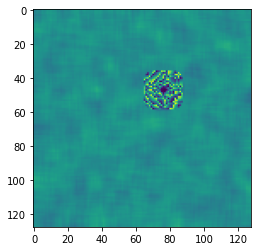

0.677228569984436
square


In [20]:
# выбор случайного батча
data = next(iter(test_set))

# отсечение одной картинки из батча
img, label = data[0][0].squeeze(0),data[1][0]
plt.imshow(img)

plt.show()

# определение отклика
image = data[0][:1]
output = net(image).squeeze()
print(output.item())
predicted = torch.heaviside(output-threshold, torch.tensor([1.])).int()

# вывод относительно порога
classes = ['circle','square']
print(classes[predicted])

## На конкретном файле

circle
1.4077043033466907e-06


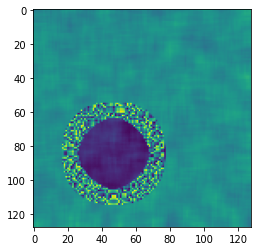

In [19]:
# выбор случайного имени
r = np.random.randint(1,n)
f = np.random.choice(['circle','square'])
fname = './figures/{}s/{}{}.png'.format(f,f,r)
# fname = './figures/squares/square20.png'

# чтение с диска
img_array = cv2.imread(os.path.join('.', fname), cv2.IMREAD_GRAYSCALE)# чтение картинки в чб
new_array = cv2.resize(img_array, (img_size, img_size))# масштабирование картинки под нейронку
X = []
for features in new_array:
    X.append(features)
X = np.array(X).reshape(img_size, img_size,1)

# наложение тех же трансформаций, что и на датасет обучения
tr = transforms.Compose([transforms.ToPILImage(),transforms.GaussianBlur(9,9),transforms.ToTensor()])
X = X + np.array(torch.rand(img_size,img_size,1))
X = tr(X)

plt.imshow(X[0])

# сеть принимает батч, т.е. имитируем его в кол-ве одной картинки
tX = X.unsqueeze(1)
output = net(tX).squeeze()

# вывод относительно порога
classes = ['circle','square']
predicted = torch.heaviside(output-threshold,torch.tensor([1.])).int()
print(classes[predicted])
print(output.item())